In [2]:
%reload_ext autoreload
%autoreload 2

In [153]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import numpy as np
from scipy.spatial import cKDTree

class ClusterFeature:
    def __init__(self):
        self.n_vectors = 0
        self.vector_sum = None
        self.squared_vector_sum = None

    def update(self, vector):
        if self.vector_sum is None:
            self.vector_sum = vector
            self.squared_vector_sum = vector ** 2
        else:
            self.vector_sum += vector
            self.squared_vector_sum += vector ** 2
        self.n_vectors += 1

    def centroid(self):
        return self.vector_sum / self.n_vectors

    def radius(self):
        return np.sqrt(self.squared_vector_sum / self.n_vectors - np.linalg.norm(self.vector_sum / self.n_vectors) ** 2)


class BIRCH:
    def __init__(self):
        self.cluster_features = []

    def insert(self, vector):
        cf = ClusterFeature()
        cf.update(vector)
        self.cluster_features.append(cf)

    def get_centroids(self):
        return [cf.centroid() for cf in self.cluster_features]

    def get_radii(self):
        return [cf.radius() for cf in self.cluster_features]


class AnomalyDetection:
    def __init__(self):
        self.birch = BIRCH()

    def train(self, data):
        for vector in data:
            self.birch.insert(vector)
        self.tree = cKDTree(self.birch.get_centroids())
        self.radii = np.array(self.birch.get_radii())

    def is_normal(self, vector):
        distance, index = self.tree.query(vector)
        return distance <= self.radii[index]

In [136]:
import numpy as np
from sklearn.cluster import Birch

class ImprovedAnomalyDetection:
    def __init__(self, threshold=0.5, branching_factor=50):
        self.birch = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=None)

    def train(self, data):
        self.birch.fit(data)
        self.centroids_ = self.birch.subcluster_centers_
        self.radii_ = self.collect_radius()
        assert len(self.centroids_) == len(self.radii_), f"len(self.centroids_)={len(self.centroids_)} != len(self.radii_)={len(self.radii_)}"
    
    def _get_leaves(self):
        leaf_ptr = self.birch.dummy_leaf_.next_leaf_
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves

    def collect_radius(self):
        radii = []
        for leave in self._get_leaves():
            for subcluster in leave.subclusters_:
                radii.append(subcluster.radius)
        return np.array(radii)

    def is_normal(self, x) -> bool:
        distances = np.array([np.linalg.norm(c - x) for c in self.centroids_])
        return bool(np.any(distances <= self.radii_))


In [6]:
import sys
sys.path.append("../")

from meltria import loader

In [8]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [271]:
metrics_files = !find "/datasets/argowf-chaos-{SOCKSHOP_DATASET_ID}/" -type f -name "*.json"
records = loader.load_dataset(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=4*45, # 45min
)

In [280]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=False,
)

In [377]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "catalogue")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape

(180, 188)

In [378]:
# TODO: Cluster of each component

anomalous_start_idx = 120
anomalous_data = dataset.iloc[anomalous_start_idx:, :]
normal_data = dataset.iloc[anomalous_start_idx - (dataset.shape[0] - anomalous_start_idx):anomalous_start_idx, :]
print(f"normal: {normal_data.shape}", f"anomalous: {anomalous_data.shape}")

normal_mu, normal_sigma = normal_data.mean(), normal_data.std()

def _zscore(x, mu, sigma):
    if sigma == .0:
        sigma = 1
    return (x - mu) / sigma

normal_data = normal_data.apply(lambda x: _zscore(x, normal_mu[x.name], normal_sigma[x.name]), axis=0)

adtector = ImprovedAnomalyDetection(threshold=10, branching_factor=50)
adtector.train(normal_data.values.T)

results: list[tuple[str, bool, np.ndarray]] = []
for col in anomalous_data.columns:
    x = _zscore(anomalous_data[col].values, normal_mu[col], normal_sigma[col])
    results.append((col, adtector.is_normal(x), dataset[col].values))

normal: (60, 188) anomalous: (60, 188)


In [379]:
results_df = pd.DataFrame(results, columns=["metric", "is_normal", "values"])
# display the ratio of normal and abnormal data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.groupby("is_normal").count())
    display(results_df.sort_values("is_normal"))

metric  values
is_normal                
False         117     117
True           71      71

metric  is_normal  \
93               c-shipping_cpu_usage_seconds_total      False   
121                          c-orders-db_memory_rss      False   
117     c-orders-db_cpu_cfs_throttled_periods_total      False   
115                     c-orders-db_fs_writes_total      False   
114               c-orders-db_fs_writes_bytes_total      False   
113              c-orders-db_cpu_user_seconds_total      False   
110            c-orders-db_memory_working_set_bytes      False   
109               c-orders-db_cpu_cfs_periods_total      False   
108             c-orders-db_cpu_usage_seconds_total      False   
107                              c-shipping_threads      False   
106                   c-shipping_memory_usage_bytes      False   
104                            c-shipping_last_seen      False   
103                           c-shipping_memory_rss      False   
101      c-shipping_cpu_cfs_throttled_seconds_total      False   
99       c-shipping_cpu_cfs_throttled_periods_total      False   
98              c-shipping_cpu_system_seconds_total      False   
97                c-shipping_cpu_user_seconds_total      False   
95              c-shipping_memory_working_set_bytes      False   
72      c-front-end_cpu_cfs_throttled_seconds_total      False   
74                           c-front-end_memory_rss      False   
75                            c-front-end_last_seen      False   
77                   c-front-end_memory_usage_bytes      False   
78                 c-orders_cpu_usage_seconds_total      False   
79                   c-orders_cpu_cfs_periods_total      False   
122                           c-orders-db_last_seen      False   
82                  c-orders_cpu_user_seconds_total      False   
86         c-orders_cpu_cfs_throttled_seconds_total      False   
87            c-orders_network_transmit_bytes_total      False   
88                              c-orders_memory_rss      False   
89                               c-orders_last_seen      False   
186                               s-user_throughput      False   
94                 c-shipping_cpu_cfs_periods_total      False   
83                c-orders_cpu_system_seconds_total      False   
70      c-front-end_cpu_cfs_throttled_periods_total      False   
124                        c-orders-db_memory_cache      False   
127            c-orders-db_blkio_device_usage_total      False   
184                           s-shipping_throughput      False   
182                            s-payment_throughput      False   
181                                s-orders_latency      False   
180                             s-orders_throughput      False   
179                             s-front-end_latency      False   
177                          s-front-end_throughput      False   
176                             s-catalogue_latency      False   
175                          s-catalogue_throughput      False   
174                                 s-carts_latency      False   
173                              s-carts_throughput      False   
172                       c-user_memory_usage_bytes      False   
170                               c-user_memory_rss      False   
168          c-user_cpu_cfs_throttled_seconds_total      False   
165                 c-user_cpu_system_seconds_total      False   
164                   c-user_cpu_user_seconds_total      False   
162                 c-user_memory_working_set_bytes      False   
160                  c-user_cpu_usage_seconds_total      False   
129               c-user-db_cpu_usage_seconds_total      False   
131              c-user-db_memory_working_set_bytes      False   
133                c-user-db_cpu_user_seconds_total      False   
134                 c-user-db_fs_writes_bytes_total      False   
135                       c-user-db_fs_writes_total      False   
136              c-user-db_cpu_system_seconds_total      False   
126                  c-orders-db_memory_usage_bytes      False   
139       c-user-db

In [380]:
from eval.groundtruth import check_cause_metrics
from eval.tsdr import recall_of_cause_metrics

anomalous_metrics = results_df.query("is_normal == False")["metric"].values.tolist()
_, found_cause_metrics = check_cause_metrics(sockshop_pk, anomalous_metrics, record.chaos_type(), record.chaos_comp(), optional_cause=False)
_, total_cause_metrics = check_cause_metrics(sockshop_pk, dataset.columns.tolist(), record.chaos_type(), record.chaos_comp(), optional_cause=False)
print(recall_of_cause_metrics(set(total_cause_metrics), set(found_cause_metrics.tolist())))

_, found_cause_metrics = check_cause_metrics(sockshop_pk, anomalous_metrics, record.chaos_type(), record.chaos_comp(), optional_cause=True)
_, total_cause_metrics = check_cause_metrics(sockshop_pk, dataset.columns.tolist(), record.chaos_type(), record.chaos_comp(), optional_cause=True)
print(recall_of_cause_metrics(set(total_cause_metrics), set(found_cause_metrics)))
print(found_cause_metrics)
diff_cause_metrics = set(total_cause_metrics) - set(found_cause_metrics)
diff_cause_metrics

1.0
0.9166666666666666
c-catalogue_cpu_usage_seconds_total,c-catalogue_cpu_cfs_periods_total,c-catalogue_memory_working_set_bytes,c-catalogue_cpu_user_seconds_total,c-catalogue_cpu_system_seconds_total,c-catalogue_cpu_cfs_throttled_periods_total,c-catalogue_memory_rss,c-catalogue_memory_cache,c-catalogue_memory_usage_bytes,c-catalogue_threads,c-catalogue_memory_mapped_file


{c-catalogue_cpu_cfs_throttled_seconds_total}

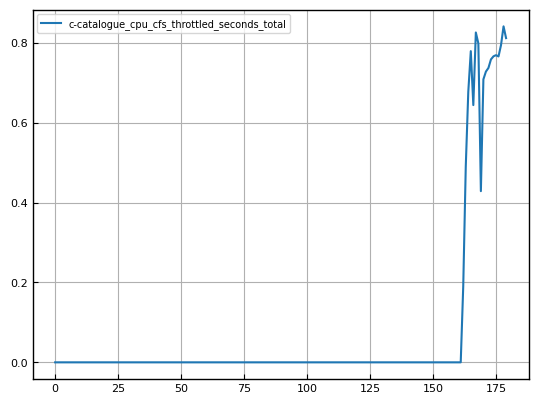

In [381]:
if len(diff_cause_metrics) > 0:
    dataset[list(diff_cause_metrics)].plot(subplots=True)

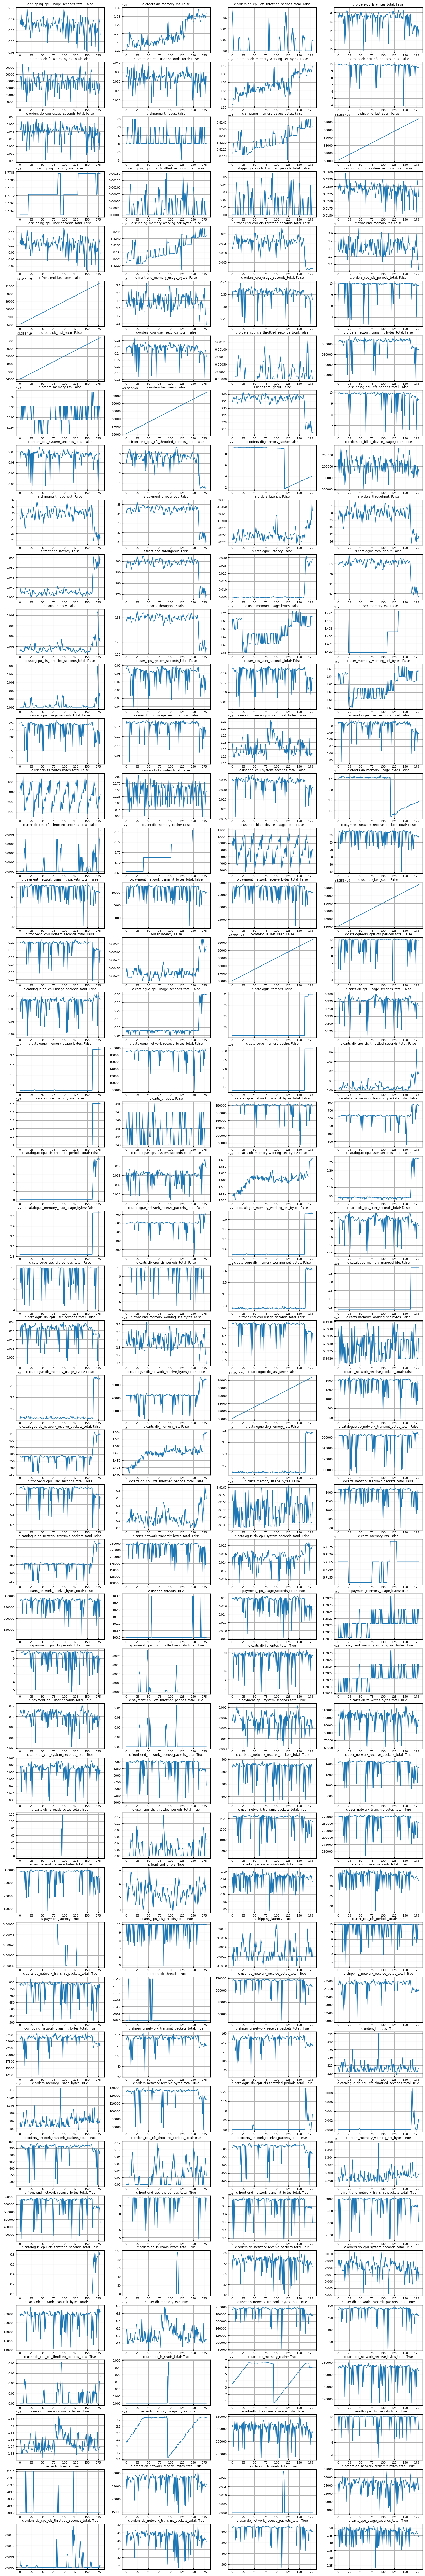

In [382]:
import math

_results_df = results_df
ncols = 4
nrows = math.ceil(_results_df.shape[0] / ncols)
fig, axs = plt.subplots(figsize=(20, 2.7 * nrows), nrows=nrows, ncols=ncols)
for (index, data), ax in zip(_results_df.sort_values("is_normal").iterrows(), axs.flatten()):  # type: ignore
    ax.plot(data["values"])
    ax.set_title(f"{data['metric']}: {data['is_normal']}")